# Wujciak Final Project - Predicting a Year for an NFL Running Back

In [1611]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pandas import Series
from matplotlib import pyplot
plt.style.use('ggplot')
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA

#### Import files for running back statistics and vitals from each player

In [1612]:
bs = pd.read_csv('../Final Project/Basic_Stats.csv')
rb = pd.read_csv('../Final Project/Game_Logs_Runningback 2.csv')

#### Remove stats from before 1980. Considering this the modern era of football.

In [1613]:
rb = rb.loc[(rb.Year > 1979)]
# rb.Year.sort_values().head(2)

#### Merge stats with player vitals

In [1614]:
bs = bs.set_index(['Player Id'])
rb = rb.set_index(['Player Id'])

In [1615]:
rb = rb.merge(bs)

#### Search for then select the player you are interested in evaluating. This will narrow our dataframe and make the below cleanup run faster

In [1645]:
# search for a player's exact name. some are hard to spell
search_player = 'Gore'
search = rb[rb['Name'].str.contains(search_player)]
search.Name.unique()

array(['Gore, Frank'], dtype=object)

In [1646]:
evaluate_player = 'Gore, Frank'
evaluate_metric = 'Rushing Yards'
eval = rb.loc[(rb['Name']==evaluate_player) & (rb['Season'] == 'Regular Season')]

#### Clean Up Data

In [1647]:
# drop unnecessary columns
eval = eval.drop(['Birth Place',
 'Birthday','High School',
 'High School Location',
 'Number','Years Played','Experience','Current Status','Current Team','Age'], axis=1, inplace=False)

In [1648]:
# fix empty data and numeric issues
eval = eval.replace('--',0)
eval['Longest Rushing Run'] = eval['Longest Rushing Run'].map(lambda x: str(x).rstrip('T'))
eval['Longest Reception'] = eval['Longest Reception'].map(lambda x: str(x).rstrip('T'))
eval = eval.apply(pd.to_numeric, errors='ignore')

In [1649]:
# create a timestamp as the index and make sure year is included and correctly sorted
eval["Game Date"] = eval["Game Date"].map(str) + "/" + eval["Year"].map(str)
# dont run this code more than once. if you need to rerun this, rerun all cells before

In [1650]:
eval["Game Date"] = pd.to_datetime(eval["Game Date"])
eval_time = eval
eval_time = eval_time.set_index('Game Date')
eval_time = eval_time.sort_index()

In [1651]:
# create a column with player experience
# need to create a rookie year column to this most efficiently. then we drop it.
def get_rookie_year(name):
   rookie_year = eval_time.loc[eval_time['Name'] == name, 'Year'].min()
   return rookie_year

eval_time['Rookie Year'] = eval_time.apply(lambda x:get_rookie_year(x['Name']),axis=1)
eval_time['Experience'] = eval_time['Year'] - eval_time['Rookie Year']
eval_time = eval_time.drop(['Rookie Year'], axis=1, inplace=False)

In [1652]:
# make consistent numeric datatype
int_cols = ['Year', 
            'Week', 
            'Games Played', 
            'Games Started', 
            'Rushing Attempts', 
            'Rushing Yards', 
            'Longest Rushing Run', 
            'Rushing TDs', 
            'Receptions', 
            'Receiving Yards', 
            'Longest Reception', 
            'Receiving TDs', 
            'Fumbles', 
            'Fumbles Lost',
            'Experience']
for col in int_cols:
    eval_time[col] = eval_time[col].astype(float)

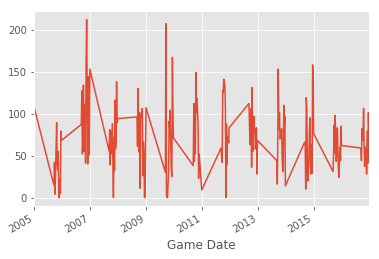

In [1653]:
eval_graph = eval_time[evaluate_metric]
eval_graph.plot()
pyplot.show()
# this is what it looks like year over year
# crazy right? football is by definition seasonal (no stats in offseason). will use a model to correct for this

In [1654]:
# eval_graph

#### Build Model

In [1655]:
# split datasets into train and test
split_point =len(eval_time[evaluate_metric])/2
train, test = eval_time[evaluate_metric][0:split_point+1], eval_time[evaluate_metric][split_point:]

# should either be +1 or +0. one of the options will error out the MSE two cells down. the other will not.
# just try both if you get an error

print('Train %d, Test %d' % (len(train), len(test)))

Train 94, Test 94


In [1656]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# create inverted differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [1657]:
# use difference function to de-seasonalize
x=eval_time[evaluate_metric].values.astype(float)
differenced = difference(x, 12)
len(differenced)

175

In [1658]:
# fit ARIMA model
model = ARIMA(differenced, order=(5,0,1))
model_fit = model.fit(disp=0)
print("Mean absolute error: ", mean_absolute_error(test, train))
print(model_fit.summary())

('Mean absolute error: ', 50.212765957446805)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  175
Model:                     ARMA(5, 1)   Log Likelihood                -964.268
Method:                       css-mle   S.D. of innovations             59.356
Date:                Wed, 04 Oct 2017   AIC                           1944.536
Time:                        09:12:57   BIC                           1969.855
Sample:                             0   HQIC                          1954.806
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0995      0.996     -0.100      0.920      -2.051       1.852
ar.L1.y        1.0484      0.076     13.884      0.000       0.900       1.196
ar.L2.

In [1659]:
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=34)[0]
# invert the differenced forecast to something usable using the above function
history = [y for y in x]
game = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, 12)
    # print('Game %d: %f' % (game, inverted))
    history.append(inverted)
    game += 1

#### Visualize for Final Decision Making

In [1660]:
# take the outputs from the model and put in a dataframe. verify count
hist = list(history)
df_hist = pd.DataFrame(hist, columns=['proj_rush_yrds'])
forecasts = len(df_hist)-34
df_hist = df_hist[forecasts:]
df_hist = df_hist.reset_index(drop=True)
df_hist.count()

proj_rush_yrds    34
dtype: int64

In [1661]:
# create a list of the dates of the 2016 and 2017 games that we test on and will project to
# basically manually adding dates on sundays for 2016 and 2017.
# games sporadically occur on a monday and thursday for tv viewing purposes so we will just pretend everything is sunday
forecast_game_dates = ['2016-01-01','2016-09-11','2016-09-18','2016-09-25','2016-10-02','2016-10-09','2016-10-16','2016-10-23', '2016-10-30', '2016-11-06', '2016-11-13', '2016-11-20', '2016-11-27', '2016-12-04', '2016-12-11', '2016-12-18', '2016-12-25',
                      '2017-01-01','2017-09-10','2017-09-17','2017-09-24', '2017-10-01', '2017-10-08', '2017-10-15', '2017-10-22', '2017-10-29', '2017-11-05', '2017-11-12', '2017-11-19', '2017-11-26', '2017-12-03', '2017-12-10', '2017-12-17', '2017-12-24'] # padding
# forecast_game_dates

In [1662]:
#dates list to dataframe. verify count
df_dates = pd.DataFrame(forecast_game_dates, columns=['game_date'])
df_dates.count()

game_date    34
dtype: int64

In [1663]:
df_forecast = df_hist.join(df_dates).set_index('game_date')

In [1664]:
# df_forecast.plot()

In [1665]:
# df_forecast

In [1666]:
# eval_graph

In [1667]:
given = eval_graph.reset_index()
predicted = df_forecast.reset_index()

In [1668]:
# if a player doesnt play on the looked-for-date below it will error
# need to see the most recent year played and adjust the looked-for-date to the start of that year
# side note: too much trouble for now to split based on football season since a season usually ends the first week of the year
# just splitting on year for now
given

,Game Date,Rushing Yards
0,2005-01-01,108.0
1,2005-09-11,17.0
2,2005-09-18,15.0
3,2005-09-25,42.0
4,2005-10-02,4.0
5,2005-10-09,31.0
6,2005-10-23,89.0
7,2005-10-30,40.0
8,2005-11-06,33.0
9,2005-11-13,55.0


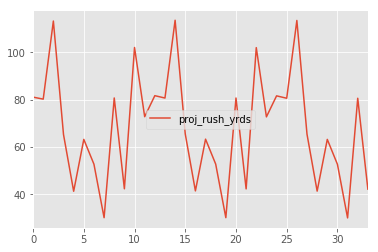

In [1669]:
# view predictions. major output for decision making
predicted.plot()

In [1670]:
# lining up the indices of projections and data we have
prediction_start_array = np.where(given['Game Date']=='2016-01-01')[0]
prediction_start_number = prediction_start_array[0]
prediction_end_number = prediction_start_number + len(predicted)
prediction_start_number, prediction_end_number

(171, 205)

In [1671]:
# lining up the indices of projections and data we have
predicted_indices = []
x = prediction_start_number
while x <= prediction_end_number :
    predicted_indices.extend([x])
    x += 1
updated_indices = pd.DataFrame(predicted_indices, columns=['new_i'])
# updated_indices

In [1672]:
# final view of our predictions. major output for decision making
predicted = predicted.join(updated_indices).set_index('new_i')
predicted

,game_date,proj_rush_yrds
new_i,,
171,2016-01-01,81.087341
172,2016-09-11,80.241734
173,2016-09-18,113.240156
174,2016-09-25,65.288959
175,2016-10-02,41.312659
176,2016-10-09,63.234510
177,2016-10-16,52.741424
178,2016-10-23,30.141299
179,2016-10-30,80.732308


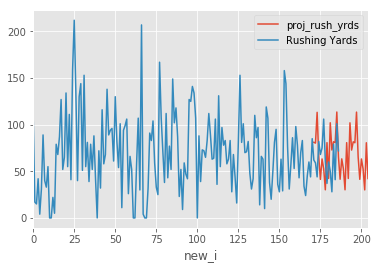

In [1673]:
# view current data into forecasted data with overlap.
# perhaps the most important output for decision making because you can see model fit and future trend
ax = predicted.plot()
given.plot(ax=ax)
pyplot.show()